# DATA ANALYSIS

# **Setup**

In [1]:
# Import all necessary libraries & packages
import pandas as pd
import numpy as np
from math import*
from time import time
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from string import punctuation
punctuation = list(punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
lemmatizer = WordNetLemmatizer()
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors

In [2]:
# This function takes the selected coffee and shuffles it to the top of a newly created duplicate dataframe
def get_dataframeNLP(df, coffee_select):
    df_coffeeSelect = df[df["Name"] == coffee_select];
    df_NLP = pd.concat([df_coffeeSelect, df]);
    df_NLP = df_NLP.drop_duplicates();
    df_NLP = df_NLP[df_NLP.columns.tolist()[1:]];
    df_NLP = df_NLP.reset_index();
    return df_NLP;

# This function outputs recommendations based on the selected coffee along with brief information and similarity score
def get_recommendations(df_NLP, coffee_select, numRec, indices, sim_measure):
    idx = indices[coffee_select];
    sim_scores = list(enumerate(sim_measure[idx]));
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True);
    sim_scores = sim_scores[1:numRec+1];
    coffee_indices = [i[0] for i in sim_scores];
    df_Rec = df_NLP[["Name","Type","Serving","Headline","Intensity","Category"]].iloc[coffee_indices];
    
    similarityScores = [];
    for i in range(len(sim_scores)):
        similarityScores.append(round(sim_scores[i][1], 4));
    df_Rec["Similarity Score"] =  similarityScores;
    
    df_Rec = df_Rec.reset_index().rename(columns={"index":"id"});
    
    return df_Rec;

In [3]:
# This function creates a word cloud showing the words that best describe the coffee in terms of significance and frequency
def get_wordcloud(df, coffee_select):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color="steelblue");
    mask = df["Name"] == coffee_select;
    idx = df.index[mask].tolist()[0];
    wc = wordcloud.generate(df.loc[idx, "Textual Info"]);
    return wc.to_image();

In [4]:
# A vectorizer and multinomial naive bayes pipeline is implemented for the purpose of performing validating the NLP parameters & feature engineering by means of classification of a target feature  
def getPipeAccuracy(dataframe, features, target, vectorizer, test_size, random_state, alpha, parameters, cv, refit):
    X_train, X_test, y_train, y_test = train_test_split(dataframe[features], dataframe[target], test_size=test_size, random_state=random_state)
    if alpha == None:
        pipe = Pipeline([
            ('tfidf', vectorizer), 
            ('mulNB', MultinomialNB())
        ]);
    else:
        pipe = Pipeline([
            ('tfidf', vectorizer), 
            ('mulNB', MultinomialNB(alpha=alpha))
        ]);
    pipe.fit(X_train, y_train);
    pipeScore = pipe.score(X_test, y_test);
    print(f'Pipe Score = {pipeScore}');
    # y_predPipe = pipe.predict(X_test);
    # print(classification_report(y_test, y_predPipe, zero_division=0));
    
    grid = GridSearchCV(pipe, param_grid=parameters, cv=cv, refit=refit, scoring='accuracy');
    grid.fit(X_train, y_train);
    print(f'Grid Best Parameter = {grid.best_params_}');
    print(f'Grid Best Score = {grid.best_score_}');
    # gridScore = grid.score(X_test, y_test);
    # print(f'Grid Score = {gridScore}');
    y_predGrid = grid.best_estimator_.predict(X_test);
    print(classification_report(y_test, y_predGrid, zero_division=0));

    data = confusion_matrix(y_test, y_predGrid);
    df_cm = pd.DataFrame(data, columns=np.unique(y_test), index=np.unique(y_test));
    df_cm.index.name = 'Actual';
    df_cm.columns.name = 'Predicted';
    chart = sns.heatmap(df_cm, annot=True,annot_kws={"size": 12}, cbar=False, vmax=np.max(data), square=True, fmt="d", cmap="Reds");
    return chart;

# **Import the Data**

In this step, we not only import the transformed coffee data, but we take a peek at it. In addition a coffee is selected for the purpose of demonstrating the data analysis portion of this project. The selected coffee is called "Intenso" and it is part of the Signature Coffee category of the Nespresso menu. This coffee is a staple of the Nespresso Vertuo menu, and is a full cup of coffee (i.e., 230ml). In a sense, it is the closest you can get to a good old fashioned roasted cup of coffee. To best introduce the selected coffee, which will be used extensively in this portion of the data analysis, a word cloud is created to serve as a descriptive snapshot.

In [5]:
# Import the prepared/transformed coffee data file as a dataframe, and take a peek at it
df = pd.read_csv('Dataset/PreparedCoffeeData.csv', index_col=False)
df.head(1)

,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Intensity Classification,Acidity Classification,Bitterness Classification,Roastness Classification,Body Classification,Milky Taste Classification,Bitterness with Milk Classification,Roastiness with Milk Classification,Creamy Texture Classification,Textual Info
0,VL01,Intenso,Vertuo,Coffee,230ml,Smooth & Strong,9.0,12.6,1.26,Why we love it: Try Intenso - a Vertuo coffee ...,...,High,Low,High,High,Medium,Medium,Medium,Medium,Medium,vertuo coffee 230ml smooth strong love try int...


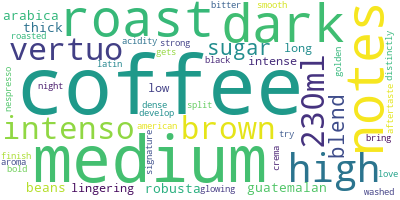

In [6]:
# Word cloud of the Intenso coffee flavour
get_wordcloud(df, 'Intenso')

In [7]:
# Split the dataframe into train and test datasets to perform classification for validation purposes
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42);

# Analysis

In this section of the data analysis, the textual analysis/feature engineering techniques such as TF-IDF, Bag-of-Words, Average Word2Vec, and Average Word2Vec x TF-IDF, are applied with _Intenso_ as the selected coffee. The measure of distance here will solely be _Cosine Similarity_ for simplicity of understanding when it comes down to retrieving top ten recommendations. The most important features with a frequency score of greater than zero based on TF-IDF and Bag-of-Words is shown both numerically in a table and graphically. Also, a pipeline of vectorization and multinomial naive bayes, as well as grid search CV, is implemented here to assist in validating the feature engineering and pre-processing with specified target feature. In this case, it is _Roast Type_ as it is the most significant-defining feature when a customer decides to select/consider a coffee flavour for purchase.

## **TF-IDF**

In [8]:
# Retrieve recommendations based on selected coffee using TF-IDF vectorization
def get_recommendationResultsTFIDF(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity):
    # t0 = time();

    df_NLP = get_dataframeNLP(df, coffee_select);
        
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    sim_measure = similarity(matrix, matrix);
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations(df, coffee_select, numRec, indices, sim_measure);
    if (similarity.__name__ != 'cosine_similarity') & (similarity.__name__ != 'linear_kernel'):
        df_Rec = df_Rec.sort_values(by='Similarity Score', ascending=True).reset_index(drop=True);
    
    # print("done in %0.3fs" % (time() - t0));
    return df_Rec;

# Retrieve most important features of selected coffee based on TF-IDF vectorization 
def get_featureResultsTFIDF(df, coffee_select, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper):
    df_NLP = get_dataframeNLP(df, coffee_select);
        
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    df_Feature = pd.DataFrame(matrix[0].T.todense(), 
        index=vectorizer.get_feature_names_out(), 
        columns=["TF-IDF"]
    );
    df_Feature = df_Feature.sort_values('TF-IDF', ascending=True);
    df_Feature = df_Feature[df_Feature["TF-IDF"] > 0];
    return df_Feature;

# General Parameters:
df = df;
coffee_select = "Intenso";
numRec = 10;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
sublinear_tf = True;
# Measure of Distance:
similarity = cosine_similarity;

In [9]:
# Top 10 recommendations based on selected coffee using TF-IDF and cosine similarity
get_recommendationResultsTFIDF(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,17,Diavolitto,Vertuo,Espresso,Highly Intense & Powerful,11.0,Espresso,0.7289
1,2,Fortado,Vertuo,Gran Lungo,Intense & Full-Bodied,8.0,Gran Lungo,0.6637
2,1,Stormio,Vertuo,Coffee,Rich & Strong,8.0,Signature Coffee,0.6574
3,10,Odacio,Vertuo,Coffee,Bold & Lively,7.0,Signature Coffee,0.6276
4,7,Arondio,Vertuo,Gran Lungo,Cereal & Mild,6.0,Gran Lungo,0.5809
5,22,Orafio,Vertuo,Espresso,Caramel & Roasted,6.0,Espresso,0.5788
6,36,Kazaar,Original,Espresso,Intense & Syrupy,12.0,Inspirazione Italiana,0.5685
7,29,Bianco Forte,Vertuo,Coffee,Full & Balanced; For Intense Recipes With Milk,7.0,Barista Creations,0.5421
8,8,Inizio,Vertuo,Gran Lungo,Floral & Cereal,4.0,Gran Lungo,0.5333
9,4,Melozio,Vertuo,Coffee,Smooth & Balanced,6.0,Signature Coffee,0.5252


In [10]:
# Important features of selected coffee using TF-IDF
df_featuresTFIDF = get_featureResultsTFIDF(df, coffee_select, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper).sort_values(by='TF-IDF', ascending=False);
df_featuresTFIDF

,TF-IDF
230ml,0.331000
dark,0.304393
robusta,0.293725
long,0.270102
coffee,0.263827
roast,0.252748
intense,0.250129
high,0.248782
vertuo,0.217567
blend,0.210561


<AxesSubplot:xlabel='TF-IDF'>

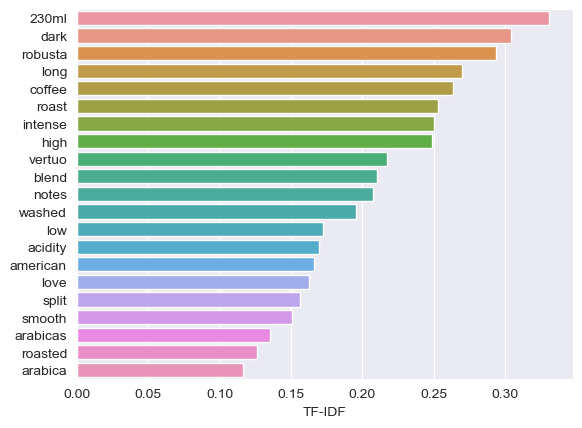

In [11]:
# Chart of important features of selected coffee using TF-IDF
sns.barplot(data=df_featuresTFIDF, x='TF-IDF', y=df_featuresTFIDF.index)

Pipe Score = 0.6428571428571429
Grid Best Parameter = {'mulNB__alpha': 0.1}
Grid Best Score = 0.7321428571428571
              precision    recall  f1-score   support

      Blonde       0.00      0.00      0.00         1
        Dark       1.00      0.25      0.40         4
      Medium       0.69      1.00      0.82         9

    accuracy                           0.71        14
   macro avg       0.56      0.42      0.41        14
weighted avg       0.73      0.71      0.64        14



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

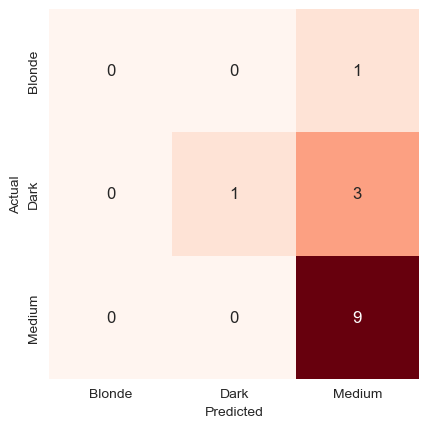

In [12]:
# TF-IDF validation by classification by scoring prediction accuracy of roast type
getPipeAccuracy(
    dataframe=df, 
    features='Textual Info', 
    target='Roast Type', 
    vectorizer=TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper)), 
    test_size=0.2, 
    random_state=42,
    alpha=None,
    parameters={
        'mulNB__alpha':[1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01]
    },
    cv=8, 
    refit=True
)

## **Bag of Words**

In [13]:
# Retrieve recommendations based on selected coffee using Bag of Words vectorization
def get_recommendationResultsBagOfWords(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper, similarity):
    # t0 = time();
    
    df_NLP = get_dataframeNLP(df_Prep, coffee_select);
    
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, analyzer=analyzer, token_pattern=token_pattern, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    sim_measure = similarity(matrix, matrix);
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations(df_NLP, coffee_select, numRec, indices, sim_measure);
    if (similarity.__name__ != 'cosine_similarity') & (similarity.__name__ != 'linear_kernel'):
        df_Rec = df_Rec.sort_values(by='Similarity Score', ascending=True).reset_index(drop=True);
    
    # print("done in %0.3fs" % (time() - t0));
    return df_Rec;

# Retrieve recommendations based on selected coffee using Bag of Words vectorization
def get_featureResultsBagOfWords(df, coffee_select, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper):
    df_NLP = get_dataframeNLP(df, coffee_select);
        
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, analyzer=analyzer, token_pattern=token_pattern, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    df_Feature = pd.DataFrame(matrix[0].T.todense(), 
        index=vectorizer.get_feature_names_out(), 
        columns=["Bag of Words"]
    );
    df_Feature = df_Feature.sort_values('Bag of Words', ascending=True);
    df_Feature = df_Feature[df_Feature["Bag of Words"] > 0];
    return df_Feature;

# General Parameters:
df = df;
coffee_select = "Intenso";
numRec = 10;
min_df = 5;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
analyzer = "word";
token_pattern = r"\b[a-zA-Z]{3,}\b";
# Measure of Distance:
similarity = cosine_similarity;

In [14]:
# Top 10 recommendations based on selected coffee using Bag of Words and cosine similarity
get_recommendationResultsBagOfWords(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,1,Stormio,Vertuo,Coffee,Rich & Strong,8.0,Signature Coffee,0.7790
1,27,Carafe Pour-Over Style,Vertuo,Carafe,Roasted & Smokey,7.0,Craft Brew,0.7631
2,37,Ristretto,Original,Espresso,Powerful & Contrasting,10.0,Inspirazione Italiana,0.7500
3,17,Diavolitto,Vertuo,Espresso,Highly Intense & Powerful,11.0,Espresso,0.7483
4,6,Half Caffeinato,Vertuo,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.7286
5,9,Solelio,Vertuo,Coffee,Fruity & Lightly-Bodied,2.0,Signature Coffee,0.7226
6,10,Odacio,Vertuo,Coffee,Bold & Lively,7.0,Signature Coffee,0.7147
7,22,Orafio,Vertuo,Espresso,Caramel & Roasted,6.0,Espresso,0.7051
8,30,Vanilla Custard Pie,Vertuo,Coffee,Sweet & Velvety; Vanilla Flavoured,6.0,Barista Creations,0.6891
9,41,Inspirazione Venezia,Original,Espresso,Balanced & Thick Body,8.0,Inspirazione Italiana,0.6827


In [15]:
# Important features of selected coffee using Bag of Words
df_featuresBagOfWords = get_featureResultsBagOfWords(df, coffee_select, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper).sort_values(by='Bag of Words', ascending=False);
df_featuresBagOfWords

,Bag of Words
coffee,8
dark,3
notes,3
high,3
roast,3
low,2
intense,2
vertuo,2
long,2
blend,2


<AxesSubplot:xlabel='Bag of Words'>

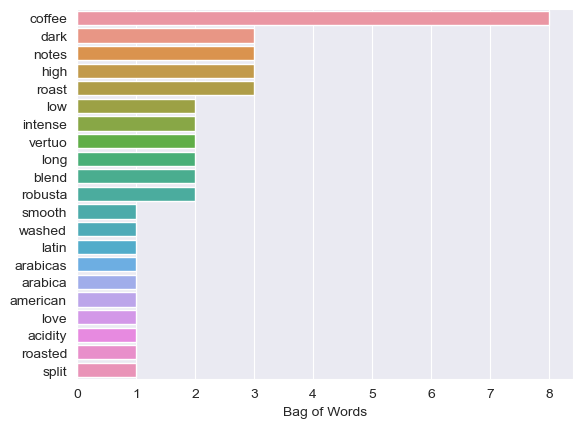

In [16]:
# Chart of important features of selected coffee using Bag of Words
sns.barplot(data=df_featuresBagOfWords, x='Bag of Words', y=df_featuresBagOfWords.index)

Pipe Score = 0.8571428571428571
Grid Best Parameter = {'mulNB__alpha': 0.09}
Grid Best Score = 0.75
              precision    recall  f1-score   support

      Blonde       0.50      1.00      0.67         1
        Dark       1.00      0.75      0.86         4
      Medium       0.89      0.89      0.89         9

    accuracy                           0.86        14
   macro avg       0.80      0.88      0.80        14
weighted avg       0.89      0.86      0.86        14



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

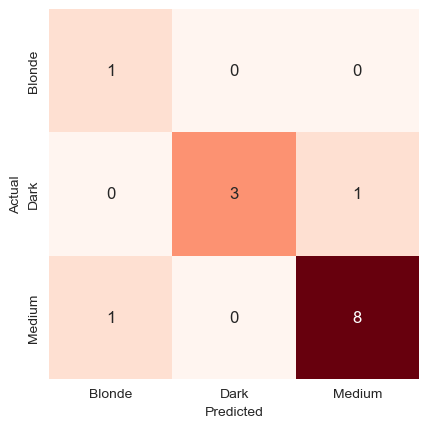

In [17]:
# Bag of Words validation by classification by scoring prediction accuracy of roast type
getPipeAccuracy(
    dataframe=df, 
    features='Textual Info', 
    target='Roast Type', 
    vectorizer=CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, analyzer=analyzer, token_pattern=token_pattern, ngram_range=(n_lower, n_upper)), 
    test_size=0.2, 
    random_state=42,
    alpha=None,
    parameters={
        'mulNB__alpha':[1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01]
    },
    cv=8, 
    refit=True
)

## **Word2Vec**
Official Pre-Trained Models: [gensim-data](https://github.com/RaRe-Technologies/gensim-data)

In [18]:
# Import pre-trained Word2Vec model
word2vec_path = 'Dataset/glove-wiki-gigaword-50.txt';
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path)

### **Average Word2Vec**

In [19]:
# Generate average word2vec for each coffee's textual info in the form of word embeddings
def get_word2vec_Avg_wordEmbeddings(df):
    wordEmbeddings = [];
    
    for info in df['Textual Info']:
        avgword2vec = None;
        count = 0;
        for word in info.split(" "):
            if word in list(word2vec_model.key_to_index.keys()):
                count += 1;
                if avgword2vec is None:
                    avgword2vec = word2vec_model[word];
                else:
                    avgword2vec = avgword2vec + word2vec_model[word];
    
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count;
            wordEmbeddings.append(avgword2vec);
    
    return wordEmbeddings;

# Retrieve recommendations based on average word2vec
def get_recommendationResultsAvgWord2Vec(df, coffee_select, numRec, similarity):
    # t0 = time();
    
    df_NLP = get_dataframeNLP(df, coffee_select);
    
    wordEmbeddings = get_word2vec_Avg_wordEmbeddings(df_NLP);
    sim_measure = similarity(wordEmbeddings, wordEmbeddings);
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations(df_NLP, coffee_select, numRec, indices, sim_measure);
    if (similarity.__name__ != 'cosine_similarity') & (similarity.__name__ != 'linear_kernel'):
        df_Rec = df_Rec.sort_values(by='Similarity Score', ascending=True).reset_index(drop=True);
    
    # print("done in %0.3fs" % (time() - t0));
    return df_Rec;

# Parameters:
df = df;
coffee_select = "Intenso";
numRec = 10;
# Measure of Distance:
similarity = cosine_similarity

In [20]:
# Top 10 recommendations based on selected coffee using average Word2Vec
get_recommendationResultsAvgWord2Vec(df, coffee_select, numRec, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,1,Stormio,Vertuo,Coffee,Rich & Strong,8.0,Signature Coffee,0.9857
1,9,Solelio,Vertuo,Coffee,Fruity & Lightly-Bodied,2.0,Signature Coffee,0.9817
2,17,Diavolitto,Vertuo,Espresso,Highly Intense & Powerful,11.0,Espresso,0.9779
3,25,Voltesso,Vertuo,Espresso,Light & Sweet,4.0,Espresso,0.9760
4,16,Il Caffè,Vertuo,Espresso,Exceptionally Intense & Velvety,11.0,Espresso,0.9757
5,20,Altissio,Vertuo,Espresso,Full-Bodied & Creamy,9.0,Espresso,0.9750
6,22,Orafio,Vertuo,Espresso,Caramel & Roasted,6.0,Espresso,0.9737
7,14,Colombia - Fairtrade,Vertuo,Coffee,Red Fruit Notes,5.0,Master Origins,0.9719
8,8,Inizio,Vertuo,Gran Lungo,Floral & Cereal,4.0,Gran Lungo,0.9711
9,53,Buenos Aires Lungo,Original,Lungo,Sweet & Cereal,4.0,World Explorations,0.9695


### **Word2Vec x TF-IDF**

In [21]:
# Generate average word2vec for each coffee's textual info in the form of word embeddings with TF-IDF
def get_word2vec_TFIDF_wordEmbeddings(df, vectorizer):
    
    tfidf_list = dict(zip(vectorizer.get_feature_names_out(), list(vectorizer.idf_)));
    tfidf_feature = vectorizer.get_feature_names_out();

    corpus = [];
    for words in df['Textual Info']:
        corpus.append(words.split());

    tfidf_vectors = [];
    count = 0;
    for info in corpus:
        sent_vec = np.zeros(50);
        weight_sum = 0;
        for word in info:
            if word in list(word2vec_model.key_to_index.keys()) and word in tfidf_feature:
                vec = word2vec_model[word];
                tf_idf = tfidf_list[word] * (info.count(word) / len(info));
                sent_vec += vec * tf_idf;
                weight_sum += tf_idf;
        if weight_sum != 0:
            sent_vec /= weight_sum;
        tfidf_vectors.append(sent_vec);
        count += 1

    return tfidf_vectors;

# Retrieve recommendations based on average word2vec x TF-IDF
def get_recommendationResultsWord2VecTFIDF(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity):
    # t0 = time();
    
    df_NLP = get_dataframeNLP(df, coffee_select);
        
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper));

    vectorizer.fit(df_NLP['Textual Info']);

    tfidf_vectors = get_word2vec_TFIDF_wordEmbeddings(df_NLP, vectorizer);
    
    sim_measure = similarity(tfidf_vectors, tfidf_vectors);
    
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations(df, coffee_select, numRec, indices, sim_measure);
    if (similarity.__name__ != 'cosine_similarity') & (similarity.__name__ != 'linear_kernel'):
        df_Rec = df_Rec.sort_values(by='Similarity Score', ascending=True).reset_index(drop=True);

    # print("done in %0.3fs" % (time() - t0));
    return df_Rec;

# General Parameters:
df = df;
coffee_select = "Intenso";
numRec = 10;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
# Unique Parameters:
sublinear_tf = True;
# Measure of Distance:
similarity = cosine_similarity;

In [22]:
# Top 10 recommendations based on selected coffee using Word2Vec x TF-IDF
get_recommendationResultsWord2VecTFIDF(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,1,Stormio,Vertuo,Coffee,Rich & Strong,8.0,Signature Coffee,0.9760
1,30,Vanilla Custard Pie,Vertuo,Coffee,Sweet & Velvety; Vanilla Flavoured,6.0,Barista Creations,0.9707
2,9,Solelio,Vertuo,Coffee,Fruity & Lightly-Bodied,2.0,Signature Coffee,0.9656
3,41,Inspirazione Venezia,Original,Espresso,Balanced & Thick Body,8.0,Inspirazione Italiana,0.9646
4,25,Voltesso,Vertuo,Espresso,Light & Sweet,4.0,Espresso,0.9638
5,27,Carafe Pour-Over Style,Vertuo,Carafe,Roasted & Smokey,7.0,Craft Brew,0.9622
6,6,Half Caffeinato,Vertuo,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.9620
7,10,Odacio,Vertuo,Coffee,Bold & Lively,7.0,Signature Coffee,0.9543
8,17,Diavolitto,Vertuo,Espresso,Highly Intense & Powerful,11.0,Espresso,0.9541
9,45,Miami Espresso,Original,Espresso,Roasted with a peppery note,9.0,World Explorations,0.9532


## **Compare Results**

In this analysis sub-section, an experiment is conducted to compare the top three recommendations based on the selected coffee and duration of code execution via a combination of textual analysis techniques and measures of distance. Below is a table summarizing the various combinations used in the experiment.

|Technique|Measure of Distance|
|--|--|
|TF-IDF|Linear Kernel|
|TF-IDF|Cosine Similarity|
|TF-IDF|Euclidean Distance|
|TF-IDF|Manhatten Distance|
|BoW|Linear Kernel|
|BoW|Cosine Similarity|
|BoW|Euclidean Distance|
|BoW|Manhatten Distance|
|Average Word2Vec|Linear Kernel|
|Average Word2Vec|Cosine Similarity|
|Average Word2Vec|Euclidean Distance|
|Average Word2Vec|Manhatten Distance|
|Average Word2Vec x TF-IDF|Linear Kernel|
|Average Word2Vec x TF-IDF|Cosine Similarity|
|Average Word2Vec x TF-IDF|Euclidean Distance|
|Average Word2Vec x TF-IDF|Manhatten Distance|

In [23]:
# All Fixed Parameters:
df = df;
coffee_select = "Intenso";
numRec = 3;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
sublinear_tf = True;
analyzer = "word";
token_pattern = r"\b[a-zA-Z]{3,}\b";

# Changing Parameters:
measure_of_distance_list = [];
for i in range(4):
    measure_of_distance_list.append('Cosine Similarity');
    measure_of_distance_list.append('Linear Kernel');
    measure_of_distance_list.append('Euclidean Distance');
    measure_of_distance_list.append('Manhattan Distance');

techniques = ['TF-IDF','Bag of Words','Average Word2Vec','Average Word2Vec x TF-IDF'];
technique_list = [];
for technique in techniques:
    for i in range(4):
        technique_list.append(technique);

In [24]:
# Retrieve recommendations and code execution time based on selected coffee, along with specified technique and measure of distance
def getRecommendationResult(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, n_lower, n_upper, sublinear_tf, analyzer, token_pattern, technique_selected, similarity_selected):
    data = [];
    row = [];
    if similarity_selected == 'Cosine Similarity':
        similarity = cosine_similarity;
    elif similarity_selected == 'Linear Kernel':
        similarity = linear_kernel;
    elif similarity_selected == 'Euclidean Distance':
        similarity = euclidean_distances;
    elif similarity_selected == 'Manhattan Distance':
        similarity = manhattan_distances;

    t0 = time();
    if technique_selected == 'TF-IDF':
        df_recommendation = get_recommendationResultsTFIDF(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity);
    elif technique_selected == 'Bag of Words':
        df_recommendation = get_recommendationResultsBagOfWords(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper, similarity);
    elif technique_selected == 'Average Word2Vec':
        df_recommendation = get_recommendationResultsAvgWord2Vec(df, coffee_select, numRec, similarity);
    elif technique_selected == 'Average Word2Vec x TF-IDF':
        df_recommendation = get_recommendationResultsWord2VecTFIDF(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity);
    time_duration = (time() - t0);

    row.append(technique_selected);
    row.append(similarity_selected);
    row.append(coffee_select);

    for i in range(3):
        row.append(df_recommendation.loc[i, 'Name']);
        row.append(df_recommendation.loc[i, 'Similarity Score']);

    row.append(time_duration);

    data.append(row);

    df_result = pd.DataFrame(data, columns=['Technique','Similarity Measure','Coffee Selected','Recommendation 1','Similarity Score 1','Recommendation 2','Similarity Score 2','Recommendation 3', 'Similarity Score 3','Code Execution Time (seconds)']);

    return df_result;

In [25]:
# Retrieve all recommendations and code execution time based on selected coffee, along with specified technique and measure of distance 
def getAllRecommendationResultsForComparison(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, n_lower, n_upper, sublinear_tf, analyzer, token_pattern, technique_list, measure_of_distance_list):
    df_list = [];
    for i in range(len(technique_list)):
        df_result = getRecommendationResult(
            df=df, 
            coffee_select=coffee_select, 
            numRec=numRec, 
            min_df=min_df, 
            max_df=max_df, 
            max_features=max_features, 
            stop_words=stop_words, 
            n_lower=n_lower, 
            n_upper=n_upper, 
            sublinear_tf=sublinear_tf, 
            analyzer=analyzer, 
            token_pattern=token_pattern, 
            technique_selected=technique_list[i], 
            similarity_selected=measure_of_distance_list[i]
        );
        df_list.append(df_result);
    df_final = pd.concat(df_list).reset_index(drop=True);
    return df_final;

In [26]:
# Top three recommendations based on selected coffee, technique, and measure of distance
getAllRecommendationResultsForComparison(df, coffee_select, numRec, min_df, max_df, max_features, stop_words, n_lower, n_upper, sublinear_tf, analyzer, token_pattern, technique_list, measure_of_distance_list)

,Technique,Similarity Measure,Coffee Selected,Recommendation 1,Similarity Score 1,Recommendation 2,Similarity Score 2,Recommendation 3,Similarity Score 3,Code Execution Time (seconds)
0,TF-IDF,Cosine Similarity,Intenso,Diavolitto,0.7289,Fortado,0.6637,Stormio,0.6574,0.073010
1,TF-IDF,Linear Kernel,Intenso,Diavolitto,0.7289,Fortado,0.6637,Stormio,0.6574,0.058255
2,TF-IDF,Euclidean Distance,Intenso,Nicaragua,1.2797,Scuro,1.2982,Paris Espresso,1.3216,0.062039
3,TF-IDF,Manhattan Distance,Intenso,Stockholm Lungo,6.6006,Colombia,6.6313,Nicaragua,6.8096,0.058465
4,Bag of Words,Cosine Similarity,Intenso,Stormio,0.7790,Carafe Pour-Over Style,0.7631,Ristretto,0.7500,0.059842
5,Bag of Words,Linear Kernel,Intenso,Bianco Forte,105.0000,Diavolitto,98.0000,Solelio,95.0000,0.052840
6,Bag of Words,Euclidean Distance,Intenso,Volutto,13.2665,Double Espresso Dolce,13.6015,Cocoa Truffle,14.4914,0.048916
7,Bag of Words,Manhattan Distance,Intenso,Volutto,56.0000,Cocoa Truffle,56.0000,Nicaragua,57.0000,0.048264
8,Average Word2Vec,Cosine Similarity,Intenso,Stormio,0.9857,Solelio,0.9817,Diavolitto,0.9779,101.418869
9,Average Word2Vec,Linear Kernel,Intenso,Voltesso,9.3686,Melozio,9.3077,Volutto Decaffeinato,9.2607,98.366863


# **Out-of-Sample Prediction**

In this part of the data analysis, the data preparation, NLP pre-processing, and data analysis steps are re-done using an out-of-sample dataset. This dataset consists of Fall 2022/Fiscal Quarter 4 2022/Christmas 2022 season coffee flavours. Similar features are evident in the out-of-sample dataset, yet the official Nespresso website/s does not provide as complete information of limited edition and seasonal coffees. Also, the recommendation retrieved for a selected out-of-sample coffee are from the regular coffee dataset.

## Import Out-of-Sample Data

In [27]:
dfVertuo_Raw_OutOfSample = pd.read_excel("Dataset/CoffeeData_OutOfSample.xlsx", index_col=False, sheet_name="Vertuo");
dfVertuo_Raw_OutOfSample = dfVertuo_Raw_OutOfSample[dfVertuo_Raw_OutOfSample['Status'] == 'Current'];

dfOriginal_Raw_OutOfSample = pd.read_excel("Dataset/CoffeeData_OutOfSample.xlsx", index_col=False, sheet_name="Original");
dfOriginal_Raw = dfOriginal_Raw_OutOfSample[dfOriginal_Raw_OutOfSample["Status"] == "Current"];

df_OutOfSample = pd.concat([dfVertuo_Raw_OutOfSample, dfOriginal_Raw_OutOfSample]).reset_index(drop=True);
df_OutOfSample.head(1)

,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Creamy Texture,Ingredients & Allergens,Number of Capsules per Sleeve,Net Weight per Total Number of Capsules,Capsule Image Link,Capsule & Sleeve Image Link,Decaf Coffee?,Category,Other Information,Status
0,VLL1,Peppermint Pinwheel,Vertuo,Coffee,230ml,Pepperming Flavored Coffee,NaN,1.37,13.7,Why we love it: Peppermint Pinwheel is inspire...,...,NaN,"Roast and ground coffee, natural flavouring. P...",10,125 g,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/ecom/medias/sys_mast...,No,Limited Edition,NaN,Current


In [28]:
df_OutOfSample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       10 non-null     object 
 1   Name                                     10 non-null     object 
 2   Type                                     10 non-null     object 
 3   Serving                                  10 non-null     object 
 4   Serving Size                             10 non-null     object 
 5   Headline                                 10 non-null     object 
 6   Intensity                                3 non-null      float64
 7   Sleeve Price                             10 non-null     float64
 8   Per Capsule Price                        10 non-null     float64
 9   Caption                                  8 non-null      object 
 10  Taste                                    10 non-null 

## Data Cleaning

In [29]:
message = "The intensity provided is an estimate as this coffee does not have an official intensity level";
nullIntensityRowIDs = df_OutOfSample[df_OutOfSample['Intensity'].isnull()].index.to_list();
for id in nullIntensityRowIDs:
    if df_OutOfSample.loc[id, 'Name'] in ['Peppermint Pinwheel','Gingerbread','Infinitely Fruity Raspberry Flavour','Exotic Liminha Over Ice']:
        df_OutOfSample.loc[id, 'Intensity'] = 5;
    else:
        df_OutOfSample.loc[id, 'Intensity'] = 6;
    df_OutOfSample.loc[id, 'Other Information'] = message;

In [30]:
tasteProfileColumns = ['Acidity','Bitterness','Roastness','Body','Milky Taste','Bitterness with Milk','Roastiness with Milk','Creamy Texture'];
for col in tasteProfileColumns:
    for id in df_OutOfSample[df_OutOfSample[col].isnull()].index.tolist():
        df_OutOfSample.loc[id, col] = 3;

In [31]:
def determineRoastType(intensity):
    if (intensity > 0) & (intensity < 5):
        return "Blonde";
    elif (intensity >= 5) & (intensity <= 8):
        return "Medium";
    else:
        return "Dark";
df_OutOfSample["Roast Type"] = df_OutOfSample.apply(lambda x: determineRoastType(x['Intensity']), axis=1);

In [32]:
def determineIntensityClassification(intensity):
    if (intensity > 0) & (intensity < 5):
        return "Low";
    elif (intensity >= 5) & (intensity <= 8):
        return "Medium";
    else:
        return "High";
df_OutOfSample["Intensity Classification"] = df.apply(lambda x: determineIntensityClassification(x['Intensity']), axis=1);

In [33]:
def determineTasteProfileClassification(tasteProfileValue):
    if (tasteProfileValue > 0) & (tasteProfileValue < 2):
        return "Low";
    elif (tasteProfileValue >= 2) & (tasteProfileValue <= 3):
        return "Medium";
    else:
        return "High";
        
for col in ['Acidity','Bitterness','Roastness','Body','Milky Taste', 'Bitterness with Milk', 'Roastiness with Milk','Creamy Texture']:
    df_OutOfSample[col + " Classification"] = df.apply(lambda x: determineTasteProfileClassification(x[col]), axis=1);

In [34]:
df_OutOfSample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       10 non-null     object 
 1   Name                                     10 non-null     object 
 2   Type                                     10 non-null     object 
 3   Serving                                  10 non-null     object 
 4   Serving Size                             10 non-null     object 
 5   Headline                                 10 non-null     object 
 6   Intensity                                10 non-null     float64
 7   Sleeve Price                             10 non-null     float64
 8   Per Capsule Price                        10 non-null     float64
 9   Caption                                  8 non-null      object 
 10  Taste                                    10 non-null 

## NLP Pre-Processing

In [35]:
NLP_Columns = [
    'Type', 
    'Serving', 
    'Serving Size', 
    'Headline',
    'Caption', 
    'Taste',
    'Best Served As', 
    'Notes', 
    'Category',
    'Roast Type',
    'Intensity Classification',
    'Acidity Classification', 
    'Bitterness Classification',
    'Roastness Classification', 
    'Body Classification',
    'Milky Taste Classification', 
    'Bitterness with Milk Classification',
    'Roastiness with Milk Classification', 
    'Creamy Texture Classification'
];

In [36]:
def process_text_for_NLP(df, NLP_Columns):
    df["Textual Info"] = "";
    for i in df.index:
        textualInfo = "";
        for col in NLP_Columns:
            textualInfo += str(df.loc[i, col]).lower() + " ";
        textualInfo = textualInfo[:-1];
        textualInfo_tokens = word_tokenize(textualInfo);
        textualInfo_cleanedTokens = [];
        for token in textualInfo_tokens:
            token = lemmatizer.lemmatize(token, pos="a");
            if (token not in stop_words) and (token not in punctuation):
                token = re.sub(r'[^\w\s]', '', token);
                if token != '':
                    if str(nlp(token)[0].pos_) not in ["PNP","PNQ","PNX","POS","AVQ","CJC","CJS","CJT","DTQ","ITJ","PRF","PRP"]:
                        textualInfo_cleanedTokens.append(token);
        textualInfo_final = "";
        for token in textualInfo_cleanedTokens:
            textualInfo_final += token + " ";
        textualInfo_final = textualInfo_final[:-1];
        df.loc[i, "Textual Info"] = textualInfo_final;
    
    return df;

df_OutOfSample_Final = process_text_for_NLP(df_OutOfSample, NLP_Columns);

In [37]:
df_OutOfSample_Final.head(1)

,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Intensity Classification,Acidity Classification,Bitterness Classification,Roastness Classification,Body Classification,Milky Taste Classification,Bitterness with Milk Classification,Roastiness with Milk Classification,Creamy Texture Classification,Textual Info
0,VLL1,Peppermint Pinwheel,Vertuo,Coffee,230ml,Pepperming Flavored Coffee,5.0,1.37,13.7,Why we love it: Peppermint Pinwheel is inspire...,...,High,Low,High,High,Medium,Medium,Medium,Medium,Medium,vertuo coffee 230ml pepperming flavored coffee...


## Out-of-Sample Data Analysis

In [38]:
# Fixed Parameters
numRec = 3;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
n_lower = 1;
n_upper = 1;
sublinear_tf = True;
analyzer = "word";
token_pattern = r"\b[a-zA-Z]{3,}\b";

# Variable Parameter
# index = random.randint(0, len(df_OutOfSample_Final)-1);
index = 0;
print('Out-of-Sample Coffee Selected: ' + df_OutOfSample_Final.loc[index, 'Name']);

Out-of-Sample Coffee Selected: Peppermint Pinwheel


In [39]:
# Top 3 recommendations based on out-of-sample coffee using TF-IDF
get_recommendationResultsTFIDF(pd.concat([df_OutOfSample_Final[index:index+1], df]).reset_index(drop=True), df_OutOfSample_Final.loc[index, 'Name'], numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,7,Half Caffeinato,Vertuo,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.5949
1,2,Stormio,Vertuo,Coffee,Rich & Strong,8.0,Signature Coffee,0.5779
2,6,Melozio Decaffeinato,Vertuo,Coffee,Smooth & Balanced,6.0,Signature Coffee,0.5550


In [40]:
# Top 3 recommendations based on out-of-sample coffee using Bag of Words
get_recommendationResultsBagOfWords(pd.concat([df_OutOfSample_Final[index:index+1], df]).reset_index(drop=True), df_OutOfSample_Final.loc[index, 'Name'], numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,7,Half Caffeinato,Vertuo,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.7163
1,2,Stormio,Vertuo,Coffee,Rich & Strong,8.0,Signature Coffee,0.7116
2,46,Miami Espresso,Original,Espresso,Roasted with a peppery note,9.0,World Explorations,0.7000


In [41]:
# Top 3 recommendations based on out-of-sample coffee using Average Word2Vec
get_recommendationResultsAvgWord2Vec(pd.concat([df_OutOfSample_Final[index:index+1], df]).reset_index(drop=True), df_OutOfSample_Final.loc[index, 'Name'], numRec, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,46,Miami Espresso,Original,Espresso,Roasted with a peppery note,9.0,World Explorations,0.9613
1,30,Bianco Forte,Vertuo,Coffee,Full & Balanced; For Intense Recipes With Milk,7.0,Barista Creations,0.9560
2,39,Ristretto Decaffeinato,Original,Espresso,Powerful & Contrasting,10.0,Inspirazione Italiana,0.9543


In [42]:
# Top 3 recommendations based on out-of-sample coffee using Average Word2Vec x TF-IDF
get_recommendationResultsWord2VecTFIDF(pd.concat([df_OutOfSample_Final[index:index+1], df]).reset_index(drop=True), df_OutOfSample_Final.loc[index, 'Name'], numRec, min_df, max_df, max_features, stop_words, sublinear_tf, n_lower, n_upper, similarity)

,id,Name,Type,Serving,Headline,Intensity,Category,Similarity Score
0,1,Intenso,Vertuo,Coffee,Smooth & Strong,9.0,Signature Coffee,0.9567
1,31,Vanilla Custard Pie,Vertuo,Coffee,Sweet & Velvety; Vanilla Flavoured,6.0,Barista Creations,0.9537
2,26,Voltesso,Vertuo,Espresso,Light & Sweet,4.0,Espresso,0.9437


In [43]:
# Retrieve accuracy scores and prediction of specified target feature using out-of-sample dataset
def getPipeAccuracy_OutOfSample(dataframe, features, target, vectorizer, test_size, random_state, alpha, parameters, cv, refit, dataframe_OutOfSample):
    X_train, X_test, y_train, y_test = train_test_split(dataframe[features], dataframe[target], test_size=test_size, random_state=random_state)
    if alpha == None:
        pipe = Pipeline([
            ('tfidf', vectorizer), 
            ('mulNB', MultinomialNB())
        ]);
    else:
        pipe = Pipeline([
            ('tfidf', vectorizer), 
            ('mulNB', MultinomialNB(alpha=alpha))
        ]);
    pipe.fit(X_train, y_train);
    pipeScore = pipe.score(dataframe_OutOfSample[features], dataframe_OutOfSample[target]);
    print(f'Pipe Score = {pipeScore}');
    # y_predPipe = pipe.predict(dataframe_OutOfSample[features]);
    
    grid = GridSearchCV(pipe, param_grid=parameters, cv=cv, refit=refit, scoring='accuracy');
    grid.fit(X_train, y_train);
    print(f'Grid Best Parameter = {grid.best_params_}');
    print(f'Grid Best Score = {grid.best_score_}');
    gridScore = grid.score(dataframe_OutOfSample[features], dataframe_OutOfSample[target]);
    print(f'Grid Score = {gridScore}');
    y_predGrid = grid.best_estimator_.predict(dataframe_OutOfSample[features]);

    df_prediction = df_OutOfSample[["Name","Type","Serving","Headline","Intensity","Category"]];
    df_prediction['Actual Roast Type'] = dataframe_OutOfSample[target];
    df_prediction['Grid Predicted Roast Type'] = y_predGrid;

    return df_prediction;

In [44]:
# Accuracy and prediction using TF-IDF
getPipeAccuracy_OutOfSample(
    dataframe=df, 
    features='Textual Info', 
    target='Roast Type', 
    vectorizer=TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf, ngram_range=(n_lower, n_upper)), 
    test_size=0.2, 
    random_state=42,
    alpha=None,
    parameters={
        'mulNB__alpha':[1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01]
    },
    cv=8, 
    refit=True,
    dataframe_OutOfSample=df_OutOfSample
)

Pipe Score = 1.0
Grid Best Parameter = {'mulNB__alpha': 0.1}
Grid Best Score = 0.7321428571428571
Grid Score = 1.0


C:\Users\kunal\AppData\Local\Temp\ipykernel_19332\3195708670.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Actual Roast Type'] = dataframe_OutOfSample[target];
C:\Users\kunal\AppData\Local\Temp\ipykernel_19332\3195708670.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Grid Predicted Roast Type'] = y_predGrid;


,Name,Type,Serving,Headline,Intensity,Category,Actual Roast Type,Grid Predicted Roast Type
0,Peppermint Pinwheel,Vertuo,Coffee,Pepperming Flavored Coffee,5.0,Limited Edition,Medium,Medium
1,Gingerbread,Vertuo,Coffee,Gingerbread Flavoured Coffee,5.0,Limited Edition,Medium,Medium
2,Infinitely Double Espresso,Vertuo,Double Espresso,Infinitely Double Espresso,6.0,Limited Edition,Medium,Medium
3,Infinitely Gourmet Hazelnut Flavour,Vertuo,Coffee,Hazelnut flavoured coffee,6.0,Limited Edition,Medium,Medium
4,Infinitely Fruity Raspberry Flavour,Vertuo,Coffee,Raspberry flavoured coffee,5.0,Limited Edition,Medium,Medium
5,Exotic Liminha Over Ice,Vertuo,Double Espresso,For exotic recipes over ice,5.0,Limited Edition,Medium,Medium
6,Galapagos,Original,Espresso,Sweet Cereal,7.0,Limited Edition,Medium,Medium
7,Infinitely Espresso,Original,Espresso,Fruity & Cereal,6.0,Limited Edition,Medium,Medium
8,Infinitely Gourmet Hazelnut Flavour,Original,Espresso,Hazelnut flavoured coffee,6.0,Limited Edition,Medium,Medium
9,Infinitely Fruity Raspberry Flavour,Original,Espresso,Raspberry Flavoured Coffee,5.0,Limited Edition,Medium,Medium


In [45]:
# Accuracy and prediction using Bag-of-Words
getPipeAccuracy_OutOfSample(
    dataframe=df, 
    features='Textual Info',
    target='Roast Type', 
    vectorizer=CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, analyzer=analyzer, token_pattern=token_pattern, ngram_range=(n_lower, n_upper)), 
    test_size=0.2, 
    random_state=42,
    alpha=None,
    parameters={
        'mulNB__alpha':[1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01]
    },
    cv=8, 
    refit=True,
    dataframe_OutOfSample=df_OutOfSample
)

Pipe Score = 0.8
Grid Best Parameter = {'mulNB__alpha': 0.1}
Grid Best Score = 0.7321428571428571
Grid Score = 0.8


C:\Users\kunal\AppData\Local\Temp\ipykernel_19332\3195708670.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Actual Roast Type'] = dataframe_OutOfSample[target];
C:\Users\kunal\AppData\Local\Temp\ipykernel_19332\3195708670.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction['Grid Predicted Roast Type'] = y_predGrid;


,Name,Type,Serving,Headline,Intensity,Category,Actual Roast Type,Grid Predicted Roast Type
0,Peppermint Pinwheel,Vertuo,Coffee,Pepperming Flavored Coffee,5.0,Limited Edition,Medium,Medium
1,Gingerbread,Vertuo,Coffee,Gingerbread Flavoured Coffee,5.0,Limited Edition,Medium,Medium
2,Infinitely Double Espresso,Vertuo,Double Espresso,Infinitely Double Espresso,6.0,Limited Edition,Medium,Medium
3,Infinitely Gourmet Hazelnut Flavour,Vertuo,Coffee,Hazelnut flavoured coffee,6.0,Limited Edition,Medium,Medium
4,Infinitely Fruity Raspberry Flavour,Vertuo,Coffee,Raspberry flavoured coffee,5.0,Limited Edition,Medium,Medium
5,Exotic Liminha Over Ice,Vertuo,Double Espresso,For exotic recipes over ice,5.0,Limited Edition,Medium,Medium
6,Galapagos,Original,Espresso,Sweet Cereal,7.0,Limited Edition,Medium,Blonde
7,Infinitely Espresso,Original,Espresso,Fruity & Cereal,6.0,Limited Edition,Medium,Medium
8,Infinitely Gourmet Hazelnut Flavour,Original,Espresso,Hazelnut flavoured coffee,6.0,Limited Edition,Medium,Medium
9,Infinitely Fruity Raspberry Flavour,Original,Espresso,Raspberry Flavoured Coffee,5.0,Limited Edition,Medium,Blonde
